In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [22]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation/numbers
    return text

df['cleaned_review'] = df['review'].apply(clean_text)


# Remove empty reviews
df = df[df['cleaned_review'].str.strip() != '']

# Verify
print(f"Empty reviews removed. New dataset size: {len(df)}")

# -----------------------------------------------------
# 2. Convert Sentiment to Numerical Values (No Changes)
# -----------------------------------------------------
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# -----------------------------------------------------
# 3. Split Data (No Changes)
# -----------------------------------------------------
X = df['cleaned_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------------------------
# 4. Tokenization and Padding (Fixed)
# -----------------------------------------------------
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Define vocab_size and max_length
vocab_size = tokenizer.num_words + 1  # +1 for OOV token
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Set max_length dynamically or to a fixed value
max_length = 200  # Or use: max(len(seq) for seq in train_sequences)
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Vocabulary Size: {vocab_size}")
print(f"Max Sequence Length: {max_length}")


Empty reviews removed. New dataset size: 50000
Vocabulary Size: 10001
Max Sequence Length: 200


In [23]:
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),  # Reduced embedding dim
    Dropout(0.3),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),        # Fewer units
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(clipvalue=1.0), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
print("Training data shape:", X_train_padded.shape)
print("Sample padded sequence:", X_train_padded[0])

Training data shape: (40000, 200)
Sample padded sequence: [ 178   47   10  757 2042  512  293    2  105 1860 1942 4190 6352    3
  798 5058   12    1    2  228    2 6032   82  865   56   52   22  102
    5    2 4152  100   36   25   38  116 1135   12    9    7 2265 1149
    6  444   47  535    6   95   34   23   40  914  422    1   16    2
  175    6 3005   24    1 4285   20    4 2877   12   43   74  222   72
  123    8   81 3051  192   20  240    3    2    1  207 4850  143   21
   62   28   16    1   79  352  293    4   19   18    9  207   26  294
   12    1    1   14    2 8175    1  115  436    3    1    1   14    2
 1619    1  619   66  408  373   10   89  117   47  111  375   34    1
   35   18   45   10   13   95  465 6767   16    4  367    1 1935    1
   60    1    1    8    2  454  217  968    6 4091    8    4  179    5
 3041  669  609   12   73  234  109  805   35  172   30  214  178    2
  415  362   59 3766    4  269    1 1646  190    7    2    1    1  710
 1824    2 1132    

In [25]:
history = model.fit(
    X_train_padded,
    y_train,
    epochs=10,
    batch_size=128,  
    validation_split=0.2
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 230ms/step - accuracy: 0.5248 - loss: 0.6909 - val_accuracy: 0.6104 - val_loss: 0.6679
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 230ms/step - accuracy: 0.6136 - loss: 0.6649 - val_accuracy: 0.6370 - val_loss: 0.6540
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 227ms/step - accuracy: 0.6572 - loss: 0.6272 - val_accuracy: 0.7335 - val_loss: 0.5646
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 228ms/step - accuracy: 0.7399 - loss: 0.5490 - val_accuracy: 0.5599 - val_loss: 0.6718
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 228ms/step - accuracy: 0.6810 - loss: 0.5853 - val_accuracy: 0.7404 - val_loss: 0.5682
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 228ms/step - accuracy: 0.6978 - loss: 0.5703 - val_accuracy: 0.7327 - val_loss: 0.5842
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 227ms/step - accuracy: 0.7811 - loss: 0.4860 - val_accuracy: 0.8061 - val_loss: 0.4692
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 227ms/step - accuracy: 0.8577 - loss: 0

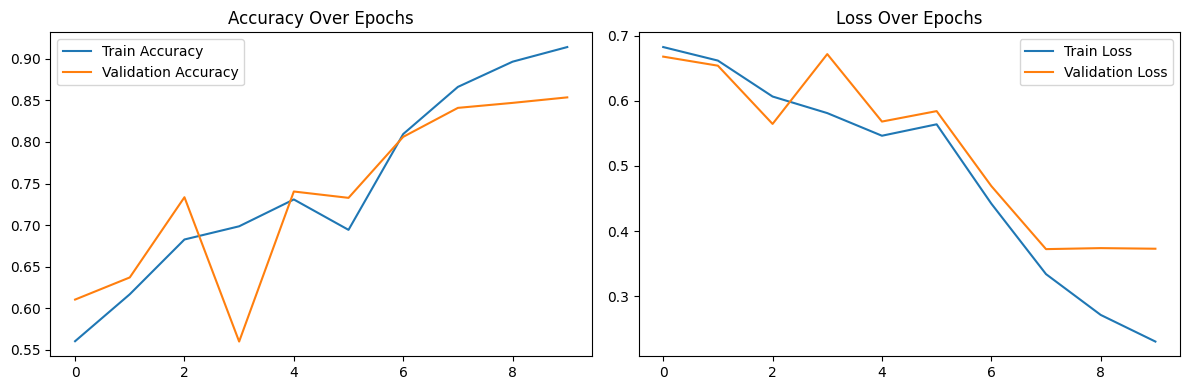

In [26]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.8653 - loss: 0.3439

Test Accuracy: 0.8642
Test Loss: 0.3511
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step


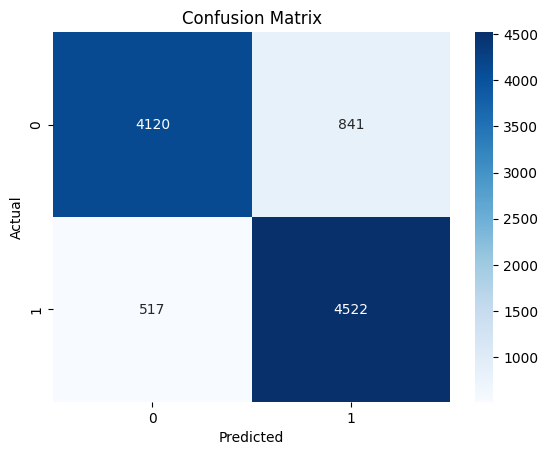


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      4961
           1       0.84      0.90      0.87      5039

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



In [27]:
# Test set evaluation
test_loss, test_acc = model.evaluate(X_test_padded, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Confusion Matrix
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [28]:
sample_text = ["This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.", 
               "Terrible waste of time. Poor acting and a nonsensical storyline."]

# Preprocess
sample_sequences = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')

# Predict
predictions = (model.predict(sample_padded) > 0.5).astype("int32")
sentiments = ['positive' if pred == 1 else 'negative' for pred in predictions]

for text, sentiment in zip(sample_text, sentiments):
    print(f"Text: {text[:60]}...\nPredicted Sentiment: {sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Text: This movie was absolutely fantastic! The acting was superb a...
Predicted Sentiment: positive

Text: Terrible waste of time. Poor acting and a nonsensical storyl...
Predicted Sentiment: negative

